In [ ]:
!pip install pandas_ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import yfinance as yf
import pandas_ta as ta
import math
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [ ]:
end_date = "2023-12-31"
start_date = "2019-01-01"

stock_tickers = ["ADANIENT.NS", "ADANIGREEN.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BHARTIARTL.NS",
    "BPCL.NS", "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HEROMOTOCO.NS",
    "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS", "INFY.NS", "ITC.NS",
    "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS", "NESTLEIND.NS",
    "NTPC.NS", "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS", "TCS.NS",
    "TECHM.NS", "TITAN.NS", "TRENT.NS", "ULTRACEMCO.NS", "UPL.NS", "WIPRO.NS"]

closing_matrix = yf.download(stock_tickers, start=start_date, end=end_date)['Close']
opening_matrix =  yf.download(stock_tickers, start=start_date, end=end_date)['Open']
volume_matrix = yf.download(stock_tickers, start=start_date, end=end_date)['Volume']
market = yf.download('^NSEI', start=start_date, end=end_date)[['Close']]

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


# ***MOMENTUM SCORING***

We are implementing a *momentum scoring system* for stocks based off **RSI** and **MACD** while also taking into account the **Volume** of the stock being traded.

In [ ]:
rsi_matrix = pd.DataFrame()

for stock in stock_tickers:
  rsi_matrix[stock] = ta.rsi(closing_matrix[stock])

*   Stocks with an RSI>60 or RSI<40 get a non-zero scoring.
*   Stocks with RSI>60 exhibiting an increasing RSI trend result a strong short signal, while a stock with RSI>60 exhibiting a decreasing RSI trend results in a weaker short signal.
*   Stocks with RSI<40 exhibiting a decreasing RSI trend result a strong buy signal, while a stock with RSI<40 exhibiting an increasing RSI trend results in a weaker buy signal.










In [ ]:
rsi_delta_matrix = pd.DataFrame()

for stock in stock_tickers:
    rsi_delta_matrix[stock] = rsi_matrix[stock] - rsi_matrix[stock].shift(1).rolling(window=4).mean()

In [ ]:
rsi_rating_matrix = pd.DataFrame()

for stock in stock_tickers:

  rsi_rating_matrix[stock] = ((rsi_matrix[stock] > 60) | (rsi_matrix[stock] < 40)).astype(int)

  # First condition: if RSI > 60 and signal > 0, multiply by -1, otherwise by 1
  rsi_rating_matrix[stock] *= np.where((rsi_matrix[stock] > 60) & (rsi_delta_matrix[stock] > 0), -1 * np.log1p(rsi_matrix[stock] - 60), 1)

  # Second condition: if RSI > 60 and signal < 0, multiply by 0.75, otherwise by 1
  rsi_rating_matrix[stock] *= np.where((rsi_matrix[stock] > 60) & (rsi_delta_matrix[stock] < 0), 0.75 * np.log1p(rsi_matrix[stock] - 60), 1)

  # Third condition: if RSI < 40 and signal < 0, multiply by 1, otherwise by 1 (no actual change here)
  rsi_rating_matrix[stock] *= np.where((rsi_matrix[stock] < 40) & (rsi_delta_matrix[stock] < 0), 1 * np.log1p(40 - rsi_matrix[stock]), 1)

  # Fourth condition: if RSI < 40 and signal > 0, multiply by -0.75, otherwise by 1
  rsi_rating_matrix[stock] *= np.where((rsi_matrix[stock] < 40) & (rsi_delta_matrix[stock] > 0), -0.75 * np.log1p(40 - rsi_matrix[stock]), 1)

rsi_rating_matrix = rsi_rating_matrix / 3 # Done to scale the values down
rsi_rating_matrix = rsi_rating_matrix.shift(1)

In [ ]:
# Volume scoring matrix
volume_delta_matrix = pd.DataFrame()

for stock in stock_tickers:
    volume_delta_matrix[stock] = volume_matrix[stock] - volume_matrix[stock].shift(1).rolling(window=4).mean()

volume_scoring_matrix = pd.DataFrame(data=np.ones(volume_matrix.shape), index=volume_matrix.index, columns=volume_matrix.columns)

for stock in stock_tickers:
    volume_scoring_matrix[stock] *= np.where(volume_delta_matrix[stock]>0, np.log10(volume_delta_matrix[stock])/2, 1)

volume_scoring_matrix = volume_scoring_matrix.shift(1)

In [ ]:
# Calculate MACD for each stock
def calculate_macd(df):
    macd = ta.macd(df, fast=12, slow=26, signal=9)  # Standard MACD settings
    return macd

# Scale values between -1 and 1 using Min-Max scaling
def scale_between_minus_one_and_one(series):
    min_val = series.min()
    max_val = series.max()
    scaled_series = 2 * (series - min_val) / (max_val - min_val) - 1
    return scaled_series

# Generate buy/sell signals based on MACD values
def generate_macd_signal(macd_df):

    # Difference between MACD line and signal line
    macd_diff = macd_df['MACDh_12_26_9']

    # Scale the difference between -1 and 1
    signal_strength = scale_between_minus_one_and_one(macd_diff)

    return signal_strength

# Backtesting logic for multiple stocks
def backtest_stocks(tickers, closing_matrix):
    data = closing_matrix.copy()

    stock_signals = closing_matrix.copy()

    # Calculate MACD signal for each stock
    for stock in tickers:
        stock_data = data[stock].dropna()
        macd_df = calculate_macd(stock_data)

        # Generate signal based on MACD
        signal = generate_macd_signal(macd_df)

        # Store the final signal value for each stock
        stock_signals[stock] = signal  # Latest signal value

    return stock_signals

macd_full_matrix = pd.DataFrame()
for st in stock_tickers:
    macd_full_matrix[st] = ta.macd(closing_matrix[st])['MACD_12_26_9']

# Main flow
macd_ratings = backtest_stocks(stock_tickers, closing_matrix)
macd_ratings = macd_ratings.shift(1)


In [ ]:
def macd_performance(df):
    performance = df.copy()

    # Calculate MACD, Signal line, and MACD Histogram using pandas_ta
    for st in stock_tickers:

      macdxx = ta.macd(df[st])

      for i in range(1, len(df)):
          # Detect MACD bullish crossover
          if macdxx['MACD_12_26_9'].iloc[i-4] <  macdxx['MACD_12_26_9'].iloc[i-3]:
              # Bullish crossover, expecting price increase
              if df[st].iloc[i] > (df[st].iloc[i-1]+df[st].iloc[i-2]+df[st].iloc[i-3]+df[st].iloc[i-4])/4:
                  performance[st].iloc[i] = 1  # Correct signal, price increased
              else:
                  performance[st].iloc[i] = -1  # Incorrect signal, price did not increase

          # Detect MACD bearish crossover
          elif macdxx['MACD_12_26_9'].iloc[i-4] >  macdxx['MACD_12_26_9'].iloc[i-3]:
              # Bearish crossover, expecting price decrease
              if df[st].iloc[i] < (df[st].iloc[i-1]+df[st].iloc[i-2]+df[st].iloc[i-3]+df[st].iloc[i-4])/4:
                  performance[st].iloc[i] = 1  # Correct signal, price decreased
              else:
                  performance[st].iloc[i] = -1  # Incorrect signal, price did not decrease

          else:
              performance[st].iloc[i] = 0  # No crossover, no signal

    return performance


def rsi_performance(df, rsi):

    performance = df.copy()
    for st in stock_tickers:

      for i in range(1, len(df)):

          if rsi[st].iloc[i-4] > 70:
              if df[st].iloc[i] < (df[st].iloc[i-1]+df[st].iloc[i-2]+df[st].iloc[i-3]+df[st].iloc[i-4])/4:
                  performance[st].iloc[i] = 1  # Correct signal
              else:
                  performance[st].iloc[i] = -1  # Incorrect signal

          elif rsi[st].iloc[i-4] < 30:
              if df[st].iloc[i] > (df[st].iloc[i-1]+df[st].iloc[i-2]+df[st].iloc[i-3]+df[st].iloc[i-4])/4:
                  performance[st].iloc[i] = 1  # Correct signal
              else:
                  performance[st].iloc[i] = -1  # Incorrect signal

          else:
              performance[st].iloc[i] = 0  # No signal

    return performance


rsi_performance = rsi_performance(closing_matrix, rsi_matrix)
macd_performance = macd_performance(closing_matrix)
# volume_performance = volume_performance(closing_matrix, volume_matrix)

for st in stock_tickers:
    macd_performance[st] = macd_performance[st].rolling(window=10).mean()
    rsi_performance[st] = rsi_performance[st].rolling(window=10).mean()
    # volume_performance[st] = volume_performance[st].rolling(window=10).mean()

In [ ]:
final_ratings = rsi_rating_matrix.copy()
for st in stock_tickers:
    rsi_rating_matrix[st] *= rsi_performance[st]
    macd_ratings[st] *= macd_performance[st]
    final_ratings[st] = rsi_rating_matrix[st] + macd_ratings[st]
    final_ratings[st] *= volume_scoring_matrix[st]

In [ ]:
def reallocating_portfolio(closing_matrix, opening_matrix, rating_matrix, net_cash, i):

    rating_array = rating_matrix.iloc[i].to_dict()

    long_dict = {key: value for key, value in rating_array.items() if 0 < value}
    long_dict = dict(sorted(long_dict.items(), key=lambda item: item[1], reverse=True))
    short_dict = {key: value for key, value in rating_array.items() if 0 > value}
    short_dict = dict(sorted(short_dict.items(), key=lambda item: item[1]))

    # selecting top 3 in long, short
    long_dict = {k: long_dict[k] for i, k in enumerate(long_dict) if i < min(8,len(long_dict))}
    short_dict = {k: short_dict[k] for i, k in enumerate(short_dict) if i < min(8,len(short_dict))}

    # normalising weight of long, short
    long_dict = {key: value / sum(long_dict.values()) for key, value in long_dict.items()}
    short_dict = {key: value / sum(short_dict.values()) for key, value in short_dict.items()}


    short_cash = net_cash // 2
    long_cash = net_cash // 2

    portfolio = {}
    # Allocate capital to long positions
    for st in long_dict.keys():
        price = opening_matrix[st].iloc[i]
        allocation = (long_dict[st] * long_cash )  # Capital allocated to this stock
        shares = allocation // price  # Number of shares
        stop_loss = price * 0.95  # 5% stop loss from the entry price
        portfolio[st] = {'shares': shares, 'entry_price': price, 'stop_loss': stop_loss}

    # Allocate capital to short positions
    for st in short_dict.keys():
        price = opening_matrix[st].iloc[i]
        allocation = (short_dict[st] * short_cash )  # Capital allocated for shorting
        shares = - (allocation // price)  # Number of shares (for short)
        stop_loss = price * 1.05  # 5% stop loss for short (stop loss above entry price)
        portfolio[st] = {'shares': shares, 'entry_price': price, 'stop_loss': stop_loss}

    return portfolio


# Function to evaluate daily portfolio performance
def evaluate_portfolio(closing_matrix, i, portfolio):
    total_return = 0
    reevaluate = False
    if not portfolio:
        return 0, True

    # Evaluate long, short positions
    for stock, data in portfolio.items():
        current_price = closing_matrix[stock].iloc[i-1]

        total_return += (current_price - data['entry_price']) * data['shares']

        # Check if stop-loss is triggered
        if data['shares'] > 0:
            if current_price <= data['stop_loss']:
                reevaluate = True

        elif data['shares'] < 0:
            if current_price >= data['stop_loss']:
                reevaluate = True


    # Return total portfolio return and whether reevaluation is needed
    return total_return, reevaluate


def check_days(start_date, current_date):
    reevaluate = False

    # Check if 14 days have passed
    if (current_date - start_date) >= 15:
        reevaluate = True

    return reevaluate


start_date = 0
current_date = start_date
portfolio = {}
net_cash = 1000000
reevaluate = False
portfolio_value = 0
max_drawdown = 0
max_portfolio = 1000000
rebalances = 0

portfolio_value_arr = pd.DataFrame(columns=['Portfolio Value','Rebalances', 'Drawdown'], index=closing_matrix.index)

for i in range(len(closing_matrix)):

    # Evaluate the portfolio
    total_return, stop_loss_hit = evaluate_portfolio(closing_matrix, i, portfolio)

    # Check if reevaluation is needed
    reevaluate = stop_loss_hit or check_days(start_date, current_date)
    portfolio_value = net_cash + total_return
    # print(portfolio_value, i)
    portfolio_value_arr['Portfolio Value'].iloc[i] = portfolio_value


    max_portfolio = max(max_portfolio, portfolio_value)
    drawdown = (portfolio_value - max_portfolio) / (max_portfolio)
    portfolio_value_arr['Drawdown'].iloc[i] = drawdown
    max_drawdown = min(max_drawdown, drawdown)

    portfolio_value_arr['Rebalances'].iloc[i] = rebalances

    if reevaluate:
        rebalances += 1
        net_cash += total_return
        # print(net_cash, i)

        # Re-run your stock ranking model and reallocate portfolio
        portfolio = reallocating_portfolio(closing_matrix, opening_matrix, final_ratings, net_cash, i)

        start_date = current_date  # Reset start date after reevaluation
        reevaluate = False

    # Move to the next day
    current_date += 1

portfolio_value_arr['Portfolio Value']/=1000000
market['Close'] /= market['Close'].iloc[0]

total_return, stop_loss_hit = evaluate_portfolio(closing_matrix, -1, portfolio)
net_cash += total_return
max_drawdown

-0.23314756987620192

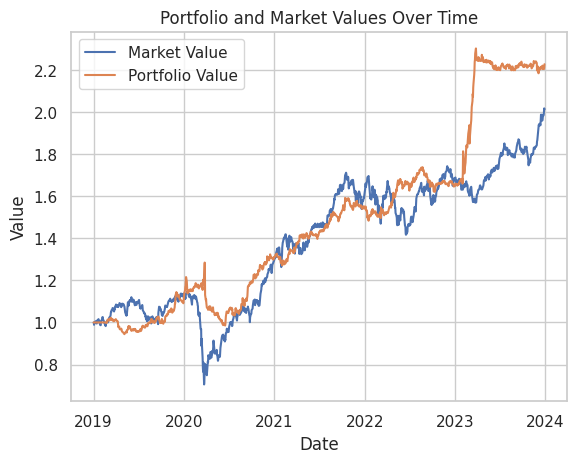

In [ ]:
# Plot both the portfolio values and the market values
plt.plot(market['Close'], label='Market Value')
plt.plot(portfolio_value_arr['Portfolio Value'], label='Portfolio Value')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio and Market Values Over Time')

# Add a legend to distinguish between the two lines
plt.legend()

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

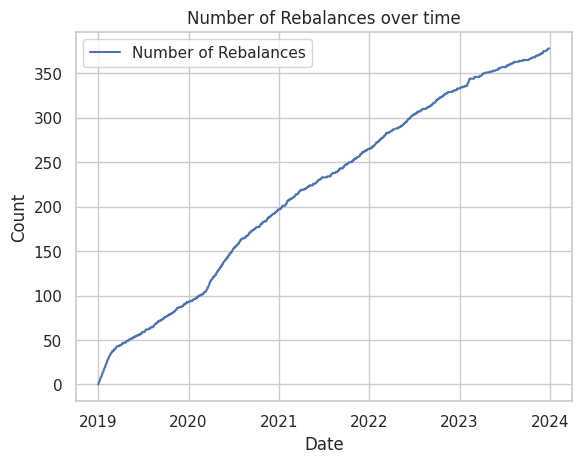

In [ ]:
plt.plot(portfolio_value_arr['Rebalances'], label='Number of Rebalances')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Rebalances over time')

# Add a legend to distinguish between the two lines
plt.legend()

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Sharpe Ratio Calculation
def sharpe_ratio(portfolio_returns, risk_free_rate=0.05):

    excess_returns = portfolio_returns - (risk_free_rate / 252)  # Daily risk-free rate
    sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()  # Annualized Sharpe Ratio
    return sharpe

# Sortino Ratio Calculation
def sortino_ratio(portfolio_returns, risk_free_rate=0.05):

    excess_returns = portfolio_returns - (risk_free_rate / 252)  # Daily risk-free rate

    # Calculate downside deviation (only consider negative returns)
    negative_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.std(negative_returns)

    # Sortino ratio (only consider downside volatility)
    sortino = np.sqrt(252) * excess_returns.mean() / downside_deviation
    return sortino


portfolio_returns = ((portfolio_value_arr['Portfolio Value'] - portfolio_value_arr['Portfolio Value'].shift(1)) / portfolio_value_arr['Portfolio Value'].shift(1))

sharpe = sharpe_ratio(portfolio_returns)
sortino = sortino_ratio(portfolio_returns)

port_returns = (portfolio_value_arr['Portfolio Value'][-1] - portfolio_value_arr['Portfolio Value'][0]) / portfolio_value_arr['Portfolio Value'][0]
mark_returns = (market['Close'].iloc[-1] - market['Close'].iloc[0]) / market['Close'].iloc[0]

print(f"Sharpe Ratio: {(sharpe).round(3)}")
print(f"Sortino Ratio: {(sortino).round(3)}")
print(f"Max Drawdown: {(max_drawdown*100).round(3)} %")
print(f"Buy and hold market returns: {mark_returns.item() * 100:.3f} %")
print(f"Portfolio returns: {(port_returns*100).round(3)} %")

Sharpe Ratio: 0.978
Sortino Ratio: 1.177
Max Drawdown: -23.315 %
Buy and hold market returns: 101.357 %
Portfolio returns: 122.787 %


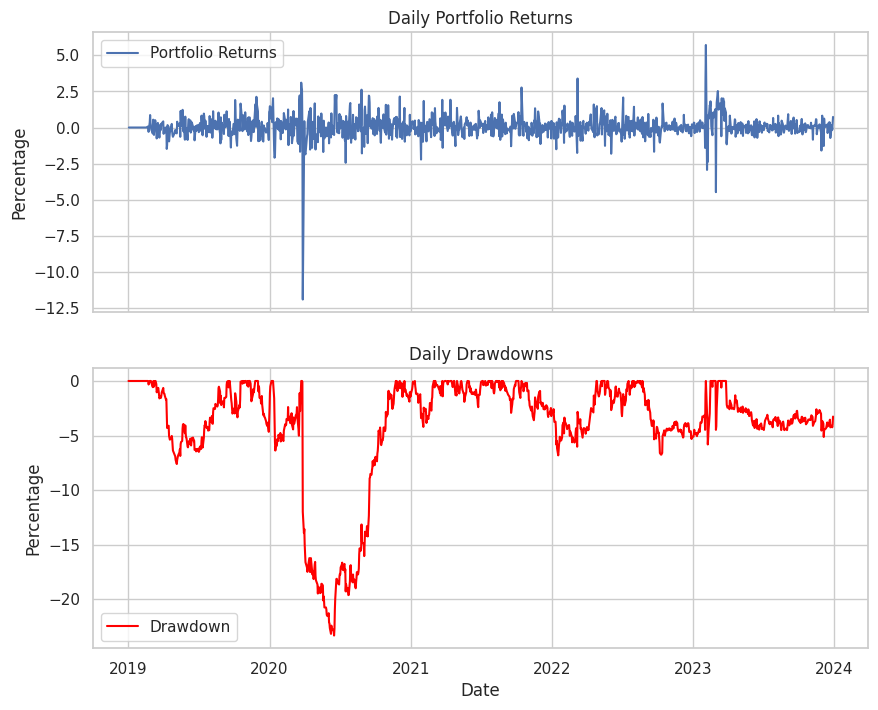

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(portfolio_returns*100, label='Portfolio Returns')
ax1.set_ylabel('Percentage')
ax1.set_title('Daily Portfolio Returns')
ax1.legend()
ax1.grid(True)

ax2.plot(portfolio_value_arr['Drawdown']*100, label='Drawdown' , c='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage')
ax2.set_title('Daily Drawdowns')
ax2.legend()
ax2.grid(True)
# plt.show()